In [3]:
import os
import avstack
import avapi
import numpy as np
import quaternion

%load_ext autoreload
%autoreload 2

obj_data_dir_k = '../../data/KITTI/object'
raw_data_dir_k = '../../data/KITTI/raw'

KOD = avapi.kitti.KittiObjectDataset
KRD = avapi.kitti.KittiRawDataset(raw_data_dir_k)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Convert raw dataset instance to the "object" format
idx_date = 0
idx_seq = 2
exp_path = KRD.convert_sequence(KRD.get_available_dates()[idx_date], idx_seq=idx_seq,
                                max_frames=None, max_time=None, tracklets_req=True)
print(f'\nRaw data has been converted to object format and saved at {exp_path}')
KDM = KOD(obj_data_dir_k, exp_path)

copying image data...
copying lidar data...
copying calibration data...
copying label data...
parsing tracklet file ../../data/KITTI/raw/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets
copying timestamp data...
writing imageset file...
done copying data! - sequence contains 154 files

Raw data has been converted to object format and saved at /data/spencer/KITTI/object/2011_09_26_drive_0005_sync


## Test Visualization

/home/spencer/.cache/pypoetry/virtualenvs/avdev-sandbox-EzsIjry5-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


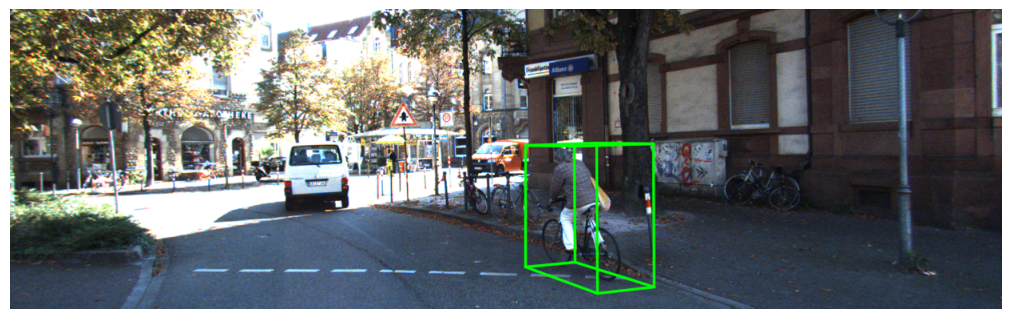

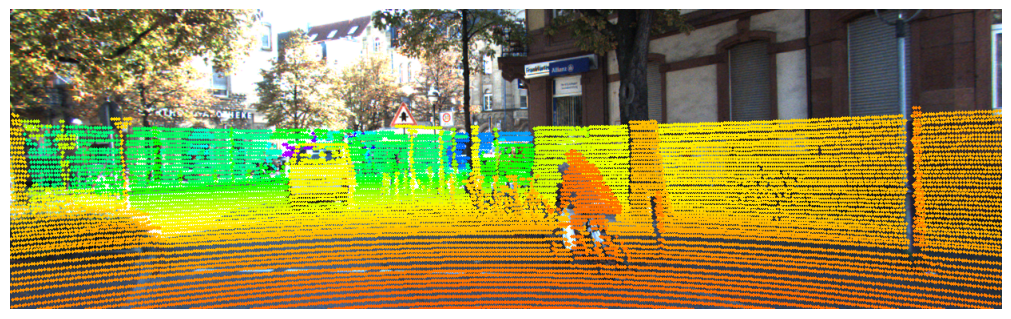

In [5]:
# Single frame visualization
frame = KDM.frames[30]
img = KDM.get_image(frame, sensor='image-2')
pc = KDM.get_lidar(frame)
objects = KDM.get_objects(frame)
avapi.visualize.snapshot.show_objects_on_image(img, objects, projection='3d', inline=True)
avapi.visualize.snapshot.show_lidar_on_image(pc, img)

## Test Detection

In [7]:
model = '3d-lidar'
if model == '2d-img':
    M = avstack.modules.perception.object2dfv.MMDetObjectDetector2D(
        model='fasterrcnn', dataset='kitti', gpu=1)
elif model == '3d-img':
    M = avstack.modules.perception.object3d.MMDetObjectDetector3D(
        model='pgd', dataset='kitti', gpu=0)
elif model == '3d-lidar':
    M = avstack.modules.perception.object3d.MMDetObjectDetector3D(
        model='pointpillars', dataset='kitti', gpu=1)
else:
    raise NotImplementedError(model)

/home/spencer/Documents/Projects/AVstack/sandboxes/avdev-sandbox/submodules/lib-avstack-core/third_party/mmdetection3d/mmdet3d/evaluation/functional/kitti_utils/eval.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_thresholds(scores: np.ndarray, num_gt, num_sample_pts=41):
/home/spencer/Documents/Projects/AVstack/sandboxes/avdev-sandbox/submodules/lib-avstack-core/third_party/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:92: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/sandboxes/avdev-sandbox/submodules/lib-avstack-core/third_party/mmdetection3d/checkpoints/kitti/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth


/home/spencer/.cache/pypoetry/virtualenvs/avdev-sandbox-EzsIjry5-py3.10/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


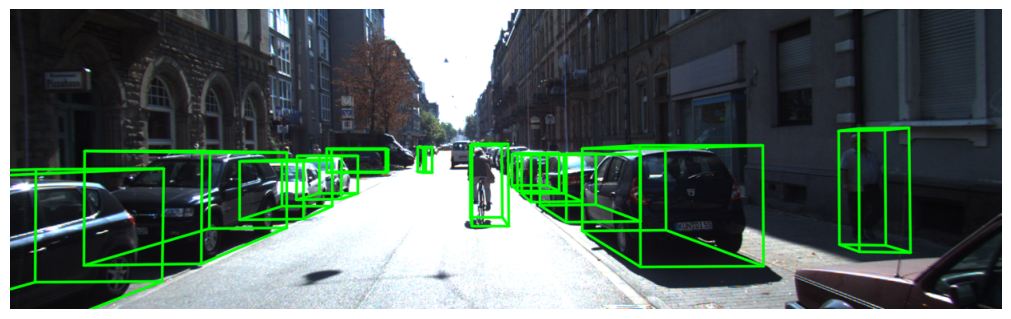

In [8]:
frame = KDM.frames[150]
img = KDM.get_image(frame, sensor='image-2')
pc = KDM.get_lidar(frame)
objects = KDM.get_objects(frame)

if model == '2d-img':
    outputs = M(img, identifier='test', frame=frame)
elif model == '3d-img':
    outputs = M(img, identifier='test', frame=frame)
elif model == '3d-lidar':
    outputs = M(pc, identifier='test', frame=frame)
else:
    raise NotImplementedError(model)
avapi.visualize.snapshot.show_image_with_boxes(img, outputs.data, inline=True)